In [ ]:
import copy
import importlib
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import shap
import torch
from collections import defaultdict
from torch_geometric.data import Data
from tqdm.notebook import tqdm

import concept_ranker
import concepts
import node_explainer
import vis
from concept_utils import *
from graph_utils import *
from pipeline import load_dataset
from pipeline import train_standard_model

In [84]:
import pickle


def strip(concepts):
    lightweight = {}
    for k, dic in concepts.items():
        dic_ = {}
        for k_, (_, v1, v2) in dic.items():
            dic_[k_] = (None, v1, v2)
        lightweight[k] = dic_
    return lightweight


def save_concepts(concepts, fname: str):
    import pickle
    d = strip(concepts)
    f = open(f'../concepts/{fname}.pkl', 'wb')
    pickle.dump(d, f, protocol=pickle.HIGHEST_PROTOCOL)


def load_concepts(fname: str):
    f = open(f'../concepts/{fname}.pkl', 'rb')
    return pickle.load(f)

In [ ]:
plt.get_cmap('Greens')(2000)

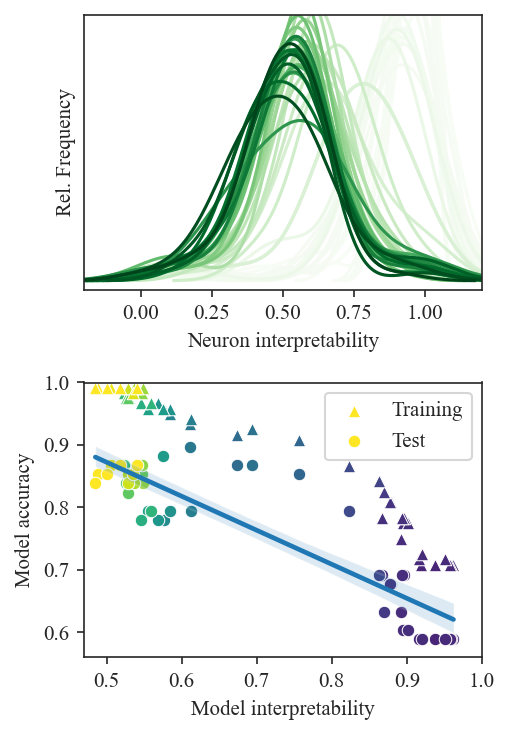

In [95]:
def build_data(neuron_ious, model, dataset):
    x = []
    y_corr = []
    y_imp = []

    for neuron in neuron_ious.keys():
        x.append(neuron_ious[neuron])

    x = np.array(x)
    y_corr = np.array(y_corr)
    y_imp = np.array(y_imp)
    return x, y_corr, y_imp


import numpy as np
import seaborn as sns

figure, axes = plt.subplots(2, 1, figsize=(3.5, 5), dpi=150)

sns.set_style('white')
sns.set_style('ticks')

plt.rcParams["font.family"] = "Times New Roman"

X_train = []
X_test = []
Y = []
es = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130,
      140, 150, 160, 170, 180, 190, 210, 220, 230, 240, 250, 260, 270, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
      390, 400]

for epochs in es:
    train_loader, test_loader, _, dataset, train_dataset, test_dataset, _ = load_dataset('MUTAG')
    model = train_standard_model('MUTAG', 'GIN', custom_name=f'mutag-train-{epochs}-epochs')
    neuron_concepts = load_concepts(f'MUTAG {epochs}')
    neuron_ious = {k: v[1] for k, v in get_best_concepts(neuron_concepts)}
    test_acc = model.evaluate(test_loader)
    train_acc = model.evaluate(train_loader)
    X_test.append(test_acc)
    X_train.append(train_acc)
    Y.append(np.mean([v for v in neuron_ious.values()]))
    x, y_corr, y_imp = build_data(neuron_ious, model, dataset)
    sns.kdeplot(np.array(x), bw_method=.75, bw_adjust=.9, c=plt.get_cmap('Greens')((epochs / 400) ** 1.2),
                label=f'{epochs}', ax=axes[0])

for i in range(len(X_train)):
    if i == len(X_train) - 1:
        sns.scatterplot(Y[i:i + 1], X_train[i:i + 1], marker='^', color=plt.get_cmap('viridis')(es[i] / 400 + 0.1),
                        ax=axes[1], label='Training')
    else:
        sns.scatterplot(Y[i:i + 1], X_train[i:i + 1], marker='^', color=plt.get_cmap('viridis')(es[i] / 400 + 0.1),
                        ax=axes[1])
for i in range(len(X_test)):
    if i == len(X_test) - 1:
        sns.scatterplot(Y[i:i + 1], X_test[i:i + 1], color=plt.get_cmap('viridis')(es[i] / 400 + 0.1), ax=axes[1],
                        label='Test')
    else:
        sns.scatterplot(Y[i:i + 1], X_test[i:i + 1], color=plt.get_cmap('viridis')(es[i] / 400 + 0.1), ax=axes[1])

axes[0].set_xlim([-.2, 1.2])
axes[0].set_ylim([-0.1, 3])

axes[1].set_ylim([0.56, 1])
axes[1].set_xlim([0.47, 1])

axes[0].set_yticks([])
axes[0].set_xlabel('Neuron interpretability')
axes[0].set_ylabel('Rel. Frequency')
axes[1].set_xlabel('Model interpretability')
axes[1].set_ylabel('Model accuracy')

plt.legend()
plt.tight_layout()
plt.savefig('../figs/mutag_epochs.pdf', pad_inches=0, bbox_inches='tight', transparent=True)

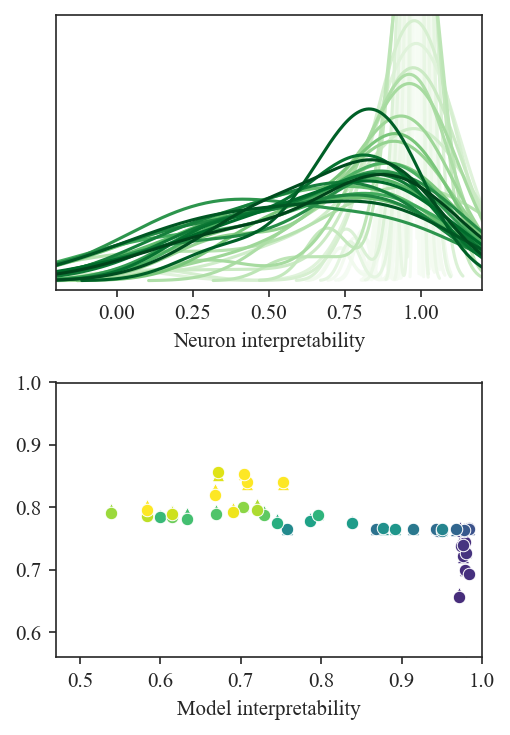

In [37]:
X_train_reddit = []
X_test_reddit = []
Y_reddit = []


def build_data(neuron_ious, model, dataset):
    x = []
    y_corr = []
    y_imp = []

    for neuron in neuron_ious.keys():
        x.append(neuron_ious[neuron])
    x = np.array(x)
    y_corr = np.array(y_corr)
    y_imp = np.array(y_imp)
    return x, y_corr, y_imp


import numpy as np
import seaborn as sns

figure, axes = plt.subplots(2, 1, figsize=(3.5, 5), dpi=150)

sns.set_style('white')
sns.set_style('ticks')

plt.rcParams["font.family"] = "Times New Roman"

es = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130,
      140, 150, 160, 170, 180, 190, 210, 220, 230, 240, 250, 260, 270, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
      390, 400]

for epochs in es:
    model = train_standard_model('REDDIT', 'GCN', custom_name=f'reddit-train-{epochs}-epochs')
    train_loader, test_loader, _, dataset, train_dataset, test_dataset, val_dataset = load_dataset('REDDIT')
    neuron_concepts = load_concepts(f'REDDIT {epochs}')
    neuron_ious = {k: v[1] for k, v in get_best_concepts(neuron_concepts)}
    if len(Y_reddit) < len(es):
        test_acc = model.evaluate(test_loader)
        train_acc = model.evaluate(train_loader)
        X_test_reddit.append(test_acc)
        X_train_reddit.append(train_acc)
        Y_reddit.append(np.mean([v for v in neuron_ious.values()]))
    x, y_corr, y_imp = build_data(neuron_ious, model, dataset)
    sns.kdeplot(np.array(x), bw=.75, c=plt.get_cmap('Greens')((epochs / 400) ** 1.2), label=f'{epochs}', ax=axes[0])

for i in range(len(X_train_reddit)):
    sns.scatterplot(Y_reddit[i:i + 1], X_train_reddit[i:i + 1], marker='^',
                    color=plt.get_cmap('viridis')(es[i] / 400 + 0.1), ax=axes[1])
for i in range(len(X_test_reddit)):
    sns.scatterplot(Y_reddit[i:i + 1], X_test_reddit[i:i + 1], color=plt.get_cmap('viridis')(es[i] / 400 + 0.1),
                    ax=axes[1])

axes[0].set_xlim([-.2, 1.2])
axes[0].set_ylim([-0.1, 3])
axes[0].set_xlabel('Neuron interpretability')
axes[0].set_ylabel('')
axes[0].set_yticks([])
axes[1].set_xlabel('Model interpretability')

axes[1].set_ylim([0.56, 1])
axes[1].set_xlim([0.47, 1])

plt.tight_layout()
plt.savefig('../figs/reddit_epochs.pdf', pad_inches=0, bbox_inches='tight', transparent=True)

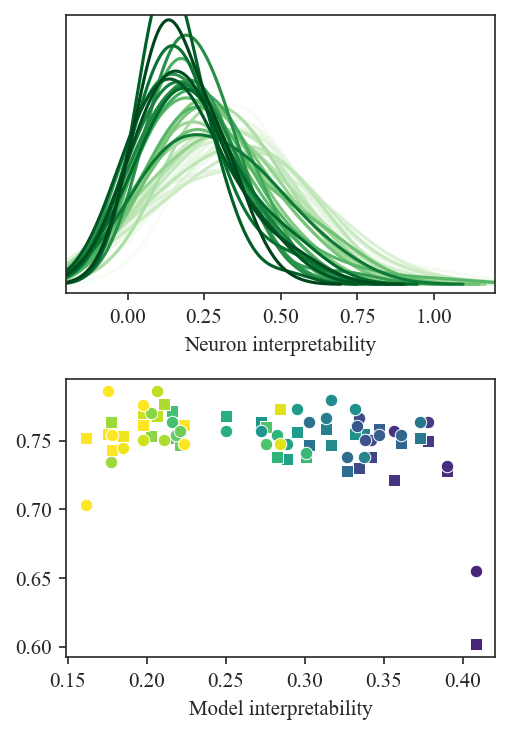

In [96]:
X_train_reddit = []
X_test_reddit = []
Y_reddit = []


def build_data(neuron_ious, model, dataset):
    x = []
    y_corr = []
    y_imp = []

    for neuron in neuron_ious.keys():
        x.append(neuron_ious[neuron])
    x = np.array(x)
    y_corr = np.array(y_corr)
    y_imp = np.array(y_imp)
    return x, y_corr, y_imp


import numpy as np
import seaborn as sns

figure, axes = plt.subplots(2, 1, figsize=(3.5, 5), dpi=150)

sns.set_style('white')
sns.set_style('ticks')

plt.rcParams["font.family"] = "Times New Roman"

es = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 210, 220, 230, 240, 250,
      260, 270, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400]

for epochs in es:
    model = train_standard_model('PROTEINS', 'GIN', custom_name=f'protein-train-{epochs}-epochs')
    train_loader, test_loader, _, dataset, train_dataset, test_dataset, val_dataset = load_dataset('PROTEINS')
    neuron_concepts = load_concepts(f'PROTEINS {epochs}')
    neuron_ious = {k: v[1] for k, v in get_best_concepts(neuron_concepts)}
    if len(Y_reddit) < len(es):
        test_acc = model.evaluate(test_loader)
        train_acc = model.evaluate(train_loader)
        X_test_reddit.append(test_acc)
        X_train_reddit.append(train_acc)
        Y_reddit.append(np.mean([v for v in neuron_ious.values()]))
    x, y_corr, y_imp = build_data(neuron_ious, model, dataset)
    sns.kdeplot(np.array(x), bw_method=.75, c=plt.get_cmap('Greens')((epochs / 400) ** 1.2), label=f'{epochs}',
                ax=axes[0])

for i in range(len(X_train_reddit)):
    sns.scatterplot(Y_reddit[i:i + 1], X_train_reddit[i:i + 1], marker='s',
                    color=plt.get_cmap('viridis')(es[i] / 400 + 0.1), ax=axes[1])
for i in range(len(X_test_reddit)):
    sns.scatterplot(Y_reddit[i:i + 1], X_test_reddit[i:i + 1], color=plt.get_cmap('viridis')(es[i] / 400 + 0.1),
                    ax=axes[1])

axes[0].set_xlim([-.2, 1.2])
axes[0].set_ylim([-0.1, 3])
axes[0].set_xlabel('Neuron interpretability')
axes[0].set_ylabel('')
axes[0].set_yticks([])
axes[1].set_xlabel('Model interpretability')


plt.tight_layout()
plt.savefig('../figs/proteins_epochs.pdf', pad_inches=0, bbox_inches='tight', transparent=True)

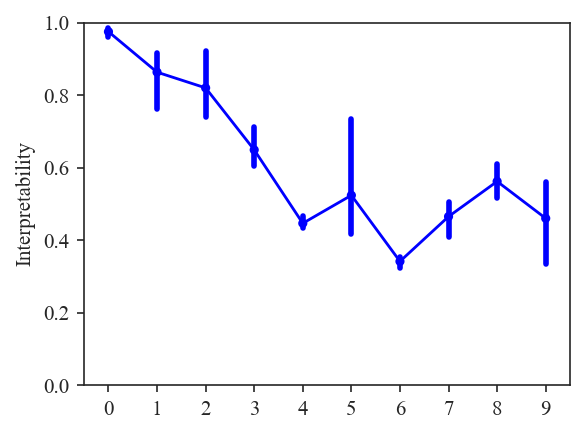

In [50]:
from neuron_metrics import *


def build_data(neuron_ious, model, dataset):
    x = []
    y_corr = []
    y_imp = []

    for neuron in neuron_ious.keys():
        x.append(neuron_ious[neuron])
    x = np.array(x)
    y_corr = np.array(y_corr)
    y_imp = np.array(y_imp)
    return x, y_corr, y_imp


import numpy as np
import seaborn as sns

figure, axes = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

sns.set_style('white')
sns.set_style('ticks')

plt.rcParams["font.family"] = "Times New Roman"


es = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 210, 220, 230, 240, 250,
      260, 270, 400]

Y1 = np.zeros((3, 10))
Y2 = np.zeros((3, 10))
std1 = []
std2 = []

for level in range(1, 11):
    for f in range(3):
        neuron_concepts = load_concepts(f'MUTAG-deep-level{level}-fold{f}')
        neuron_ious = {k: v[1] for k, v in get_best_concepts(neuron_concepts)}
        x, y_corr, y_imp = build_data(neuron_ious, None, None)
        Y1[f, 10 - level] = np.mean([v for v in neuron_ious.values()])

axes.set_ylim([0, 1])
axes.set_xticks(np.arange(11))
axes.set_ylabel('Interpretability')

sns.pointplot(data=Y1, ax=axes, color='blue', scale=.5)

plt.tight_layout()
plt.savefig('../figs/layers1.pdf', pad_inches=0, bbox_inches='tight', transparent=True)